## Example of Trans-C sampling across independent model states: Regression

This notebook demonstrates Bayesian sampling of a linear polynomial regression problem
using the Ensemble resampler.

In [1]:
# general python utility packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
from tqdm import tqdm
import corner
import time
from collections import Counter
from matplotlib.ticker import MaxNLocator
import pickle as pickle
from scipy.optimize import minimize

#### TransC class

In [2]:
from pyTransC import TransC_Sampler

In [3]:
def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return np.array(flat_list)

In [4]:
def solveLS(d,G,Cdinv): # Least squares solver
    A = np.dot(np.transpose(G), Cdinv) # Find solution
    GtG = np.dot(A, G) # G^T C_inv G^T
    GtGinv = np.linalg.inv(GtG) # Inverse of G^TC_inv G
    B = np.dot(A,d)
    mls = np.dot(GtGinv, B)
    return mls, GtGinv

In [5]:
def calcE(dp,dobs,Cdinv,Cmpost,Cmprior):
    misfit = 0.5*(np.dot((dobs-dp),np.dot(Cdinv,(dobs-dp))))
    f = np.sqrt(2*np.pi)**len(dp)
    detCdinv = np.linalg.det(Cdinv)
    detCmpost = np.linalg.det(Cmpost)
    detCmprior = np.linalg.det(Cmprior)
    E = np.sqrt(detCmpost*detCdinv/detCmprior)*np.exp(-misfit)/f
    return E

--------

## Polynomial regression set up

Here we set up a problem of polynomial regression fitting a set of x,y data with up to a 4th order polynomial.

To begin with, we will work with polynomial curves, $$y(x) = \sum_{n=0}^N m_n x^n\,.$$
Here, $N$ is the 'order' of the polynomial: if N=1 we have a straight line, if N=2 it will be a quadratic, and so on. The $m_n$ are the 'model coefficients'.

To compute $y(x)$ for multiple $x$-values simultaneously, we  write $$ \left(\begin{array}{c}y_1\\y_2\\\vdots\\y_N\end{array}\right) = \left(\begin{array}{ccc}1&x_1&x_1^2\\1&x_2&x_2^2\\\vdots&\vdots&\vdots\\1&x_N&x_N^2\end{array}\right)\left(\begin{array}{c}m_0\\m_1\\m_2\end{array}\right)$$This has the general form, $\mathbf{d=Gm}$, and so the best-fitting model can be identified using a least-squares algorithm.

Minimization of the least squares misfit measure

$$
\phi(\mathbf{m}) = \frac{1}{2}\sum_{i=1}^N (y_i- \sum_{i=j}^MG_{ij}m_j)^2/\sigma_i^2 =  \frac{1}{2} (\mathbf{d-Gm})^TC_d^{-1} (\mathbf{d-Gm})
$$

leads to

$$
\mathbf{m}_{LS} = \left(\mathbf{G^T C_D^{-1} G}\right)^\mathbf{-1}\mathbf{G^T  C_D^{-1} d}
$$

For Gaussian Likelihood and prior the evidence is a known analytical expression.

$$
p{(\bf d}) = \frac{e^{-\phi(\hat{{\bf m}})}}{(2\pi)^{N/2}} \left[ \frac{|\hat{C}_M|}{|C_D||C_M|}\right]^{1/2}.
$$

In [6]:
def getG(x,order): # build design matrix, G for polynomial data fitting, at data points x up to order order
    return np.transpose([x**(i) for i in range(order+1)])

We generate some random samples from $y=3x/5+0.3$, add Gaussian random noise to them.

In [7]:
np.random.seed(61254557)
ndata,sigma = 20,0.2
xobs = np.sort(np.random.rand(ndata)) # x values of data
mtrue = np.array([0.3,0.6])
G = getG(xobs,1)
dobs = np.dot(G,mtrue) + np.random.normal(0,sigma,size=len(xobs))
Cdinv = np.eye(ndata)/(sigma**2)

Set up prior for Evidence calculation.

In [8]:
mls, Cmpost, G, Ev, maxorder = [],[], [], [], 3
Cmprior = [20*np.eye(i+1) for i in np.arange(maxorder+1)]
muprior = [np.zeros(i+1) for i in np.arange(maxorder+1)]

Solve least squares solution and calculate evidence for each model.

In [9]:
mls, Cmpost, G, Ev, maxorder = [],[], [], [], 3
for i in range(maxorder+1):
    Gp = getG(xobs,i)
    solp, Cmp = solveLS(dobs,Gp,Cdinv)
    dpred = np.dot(Gp,solp)
    mls.append(solp)
    Cmpost.append(Cmp)
    G.append(Gp)
    Ev.append(calcE(dpred,dobs,Cdinv,Cmp,Cmprior[i]))
Ev/=np.sum(Ev)

Plot solutions.

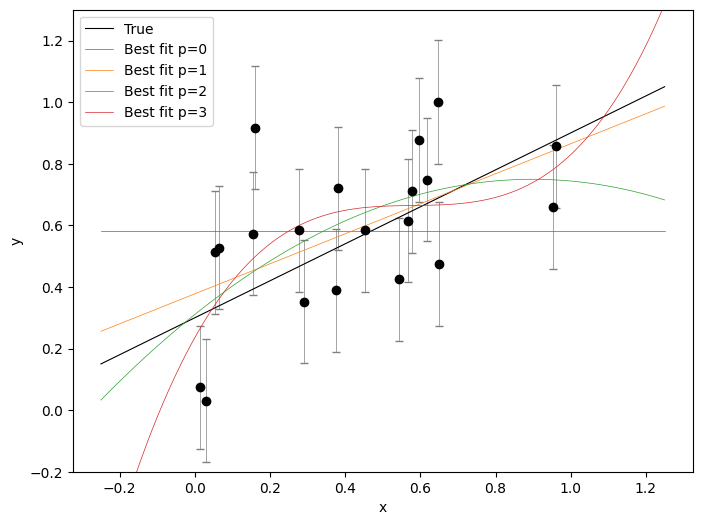

In [10]:
xplot = np.linspace(-0.25,1.25,100)
Gplot = getG(xplot,1)
dplot = np.dot(Gplot,mtrue)
#
plt.figure(figsize=(8,6))
plt.errorbar(xobs, dobs, yerr=sigma, capsize=3, fmt='ko', ecolor = "grey",lw=0.5)
plt.plot(xplot,dplot,label='True',color='k',lw=0.8)
for i in range(maxorder+1):
    Gplotp = getG(xplot,i)
    dpred = np.dot(Gplotp,mls[i])
    plt.plot(xplot,dpred,label='Best fit p='+str(i),lw=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(-0.2,1.3)
plt.legend()
plt.show()

In [11]:
Ev

array([0.16399939, 0.61471518, 0.12314481, 0.09814062])

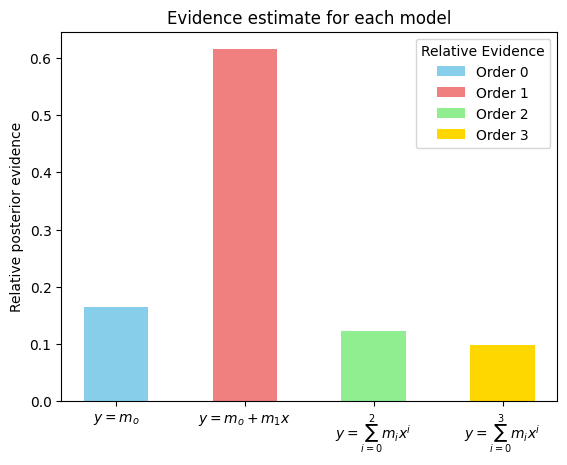

In [12]:
# plot evidence values

fig, ax = plt.subplots()

fruits = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
counts = [Ev[i] for i in range(maxorder+1)]
bar_labels = ['Order 0','Order 1', 'Order 2', 'Order 3'] # Define a list of labels, one for each bar

bar_colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'] # Define a list of colors, one for each bar

ax.bar(fruits, counts, label=bar_labels, width=0.5,color=bar_colors)

ax.set_ylabel('Relative posterior evidence')
ax.set_title('Evidence estimate for each model')
ax.legend(title='Relative Evidence')

plt.show()

In [13]:
Ev

array([0.16399939, 0.61471518, 0.12314481, 0.09814062])

----------------

Set some global control parameters.

In [14]:
plotting = True      # Create some diagnostic displays of outputs
parallel = False     # Use parallel computation for sampling

### Log-posterior Likeihood, prior and PDF for each state

In [15]:
def log_Likelihood(x,state,dobs,G,Cdinv):
    dpred = np.dot(G[state],x)
    misfit = 0.5*(np.dot((dobs-dpred),np.dot(Cdinv,(dobs-dpred))))
    f = np.sqrt(2*np.pi)**len(dpred)
    detCdinv = np.linalg.det(Cdinv)
    logL = -np.log(f) -misfit + np.log(detCdinv)
    return logL

In [16]:
def log_prior(x,state,muprior,Cmprior):
    mu = muprior[state]
    cov = Cmprior[state]
    rv = stats.multivariate_normal(mean=mu,cov=cov) # instance of multi-dimensional Gaussian
    return rv.logpdf(x)

In [17]:
def log_posterior(x,state,dobs,G, Cdinv, muprior, Cmprior): # Multi-state log Posterior PDF evaluation (unormalised)
    return log_Likelihood(x,state,dobs,G,Cdinv) + log_prior(x,state,muprior,Cmprior)
log_posterior_args = [dobs,G,Cdinv,muprior,Cmprior]

### Starting points for MCMC samplers in each state

In [18]:
# first we optimize each state to find good starting point for all McMC samplers
np.random.seed(42)
nstates = maxorder+1               # Number of distinct states
ndims  = [1,2,3,4]                 # Number of model parameters in each stateif(True):
nll = lambda *args: -log_posterior(*args)
ml = []
print("Maximum likelihood estimates:")
for i in range(nstates):
    initial = 0.5*np.ones(i+1)
    soln = minimize(nll, initial, args=(i,dobs,G,Cdinv,muprior,Cmprior))
    ml.append(soln.x)
    print("x_ml ",soln.x)

Maximum likelihood estimates:
x_ml  [0.58148024]
x_ml  [0.37788932 0.48664354]
x_ml  [ 0.31354801  0.95796058 -0.52400541]
x_ml  [ 0.28548373  1.4395107  -1.83289387  0.89632873]


-----------

Now we are ready to apply the three algorithms to sampling over the model states.

## Trans-C samping across model states with the Ensemble resampler 

Here we demonstrate use of the *Ensemble resampler*.

This formulation is equivalent to the *State-jump sampler* with the pseudo-prior being an approximation of the posterior PDF in each state. 

This consists of the following steps:
- Generate posterior ensembles in each state
- Build a pseudo prior PDF from these ensembles, and evaluate its log for all models in the ensembles.
- Sampler across the ensembles over the integer state label variable, $k$.

First instantiate the class.

In [19]:
# perform initiation of IS-sampler
tc = TransC_Sampler(nstates,ndims) # Create instances of states

Run Ensemble resampler in each state separately.

### Preliminaries 

First find good starting models in each state, and then run Ensemble resampler in each state separately.

In [30]:
# setup of MCMC sampler
nsamples_es = 4*[50000] # number of samples per chain for sampling of each state
nwalkers_es = 4*[32]    # number of mcmc chains to run in each state
pos = []
for i in range(nstates): # generate starting points for each chain in each state
    pos.append(ml[i] + 1e-4 * np.random.randn(nwalkers_es[i], ndims[i])) # add random perturbation to maximum Likelihood models

In [32]:
# run Ensemble sampler in each state
start_time = time.time()
ensemble_per_state, log_posterior_ens = tc.run_mcmc_per_state( 
        nwalkers_es,                               # int or list containing number of walkers for each state
        nsamples_es,                               # number of chain steps per walker
        pos,                                       # starting positions for walkers in each state
        log_posterior,                             # log Likelihood x log_prior
        log_posterior_args=log_posterior_args,     # log posterior additional arguments (optional)
        discard=0,                                 # burnin number of chain steps to discard in eeach state
        autothin=True,                             # thinning value, save every `thin` models
        progress=True)                             # show progress bar for each state
elapsed_time = time.time() - start_time
print(' Elapsed time                                     :', np.round(elapsed_time,2),'s \n')
print(' Number of samples in each state                  :',*[len(tc.ensemble_per_state[i]) for i in range(nstates)])


Running within-state sampler separately on each state

Number of walkers               :  [32, 32, 32, 32]

Number of states being sampled:  4
Dimensions of each state:  [1, 2, 3, 4]


100%|███████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [01:46<00:00, 469.52it/s]


 Elapsed time                                     : 424.2 s 

 Number of samples in each state                  : 114282 94114 79997 66663


In [33]:
# corner plots to check sampling within each state (if desired)
if(False):
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "darkblue"}
    data_kwargs = {"color" : "slateblue"}
    for i in range(1,nstates):
        string = 'Order '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            ensemble_per_state[i], 
            truths=ml[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

#### Build pseudo priors by fitting a Gaussian mixture to posterior ensembles in each state

Fit a mixture model in each state to create an automatic pseudo prior, and then evaluate that pseudo_prior for all points in the ensembles. This uses the posterior ensembles `TransC_Sampler.ensemble_per_state[s],s=1,...,nstates` and their log-posterior values `TransC_Sampler.log_posterior_ens[s], s=1,...,nstates`, and produces an ensemble of log-pseudo-prior values which are placed in `TransC_Sampler.log_pseudo_prior_ens[s],s=1,...,nstates`. These are then provided to the ensemble resampler `TransC_Sampler.run_ensemble_resampler`.

In [34]:
# fit a mixture model to each state to get a normalized pseudo prior PDF.
log_pseudo_prior_ens = tc.run_fitmixture(ensemble_per_state,log_posterior_ens,reg_covar=0.) 

In [35]:
# Calculate marginal Likelihoods using ensembles for each state
nwalkers_er = 32   # number of independent random walkers across ensembles
nsteps_er = 100000 # number of chain steps for each walker
start_time = time.time()
result = tc.run_ensemble_resampler(nwalkers_er,
                                   nsteps_er,
                                   progress=True,
                                   parallel=parallel,
                                   log_posterior_ens=log_posterior_ens,
                                   log_pseudo_prior_ens=log_pseudo_prior_ens) # run mcmc sampler over ensembles to get marginal Likelihoods/evidence between states
elapsed_time = time.time() - start_time


Running ensemble trans-D resampler

Number of walkers               :  32
Number of states being sampled  :  4
Dimensions of each state        :  [1, 2, 3, 4]


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:27<00:00,  1.14it/s]


In [36]:
# print some diagnostics
print('\n Algorithm type                                      :', tc.alg)
print(' Average % acceptance rate for within states         :',np.round(tc.accept_within,2))
print(' Average % acceptance rate for between states        :',np.round(tc.accept_between,2))

# extract trans-D samples and chains
discard = 0                  # chain burnin
thin = 15                    # chain thinning
chain,states_chain = tc.get_visits_to_states(discard=discard,thin=thin,normalize=True,
                                               walker_average='median',return_samples=True)

print(' Auto correlation time for between state sampling    :',np.round(tc.autocorr_time_for_between_state_jumps,3))
print(' Total number of state changes for all walkers       :',tc.total_state_changes)
print(' Number of state changes for each walker             :\n',*tc.state_changes_perwalker)
print(' Analytic relative marginal Likelihoods              :', *np.round(Ev,5))
print(' Estimated relative evidences                        :', *np.round((tc.relative_marginal_likelihoods),5))
print(' Elapsed time                                        :', np.round(elapsed_time,2),'s \n')


 Algorithm type                                      : TransC-ensemble-resampler
 Average % acceptance rate for within states         : 100.0
 Average % acceptance rate for between states        : 39.06
 Auto correlation time for between state sampling    : 0.981
 Total number of state changes for all walkers       : 113204
 Number of state changes for each walker             :
 3581 3530 3555 3647 3580 3543 3497 3575 3531 3497 3534 3569 3584 3505 3508 3524 3531 3468 3512 3551 3497 3523 3610 3520 3576 3428 3655 3550 3539 3416 3507 3561
 Analytic relative marginal Likelihoods              : 0.164 0.61472 0.12314 0.09814
 Estimated relative evidences                        : 0.17276 0.64786 0.12503 0.05435
 Elapsed time                                        : 28.0 s 



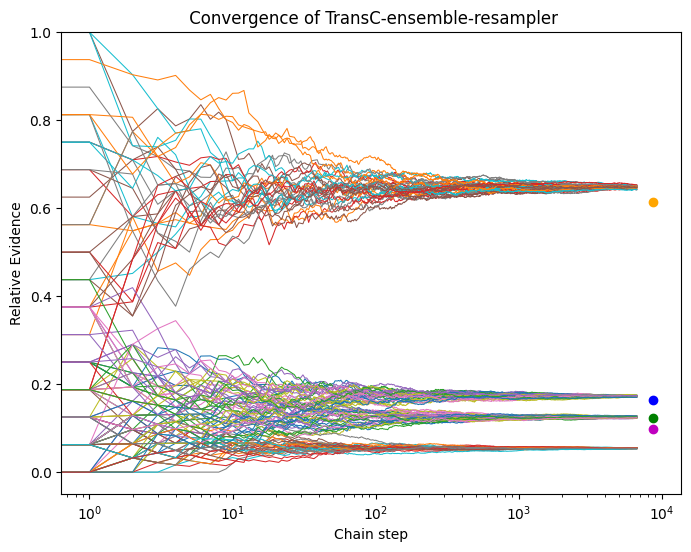

In [37]:
# plot relative number of visit to each state along the chain
if(plotting):
    key = tc
    fig, axes = plt.subplots(figsize=(8,6))
    if(chain.ndim == 3): # plot chains for each state and walker
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75)
    elif(chain.ndim==2): # plot chains for each state average over walkers
        plt.semilogx(chain.reshape(np.shape(chain)[0],-1),lw=0.75,label=['State 1','State 2','State 3'])
        plt.legend()
    plt.xlabel('Chain step')
    plt.ylabel('Relative Evidence')
    plt.plot(len(chain)*1.3,Ev[0],'bo')
    plt.plot(len(chain)*1.3,Ev[1],'o',color='orange')
    plt.plot(len(chain)*1.3,Ev[2],'go')
    plt.plot(len(chain)*1.3,Ev[3],'mo')
    plt.title(' Convergence of '+key.alg)
    plt.ylim(-0.05,1.0)

    plt.show()

Coloured dots show the true relative normalization constants for each Gaussian. As you can see the chains of the Product-space sampler are 
converging, and visiting each state in proportion to the correct normalization constant. 

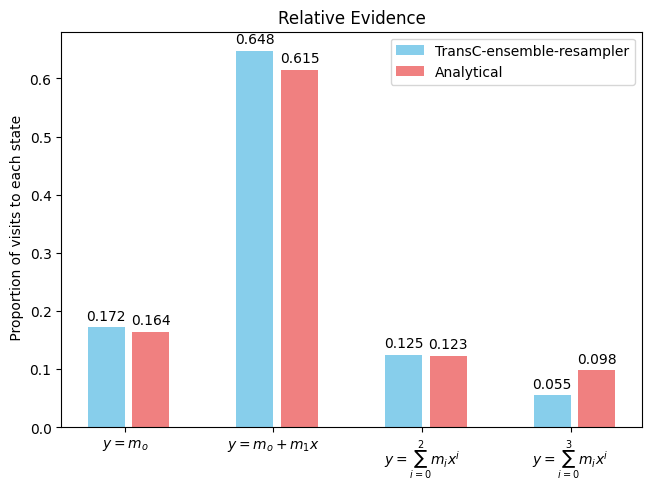

In [38]:
# Count visits to each state by Trans-D mcmc
if(plotting):
    h=np.zeros(key.nstates)
    h[list(Counter(states_chain.reshape(-1)).keys())] = list(Counter(states_chain.reshape(-1)).values())
    h/=np.sum(h)
    # plot histogram of frequency of visits to each state

    labels = [r'$y=m_o$', r'$y=m_o + m_1x$', r'$y = \sum_{i=0}^2 m_ix^i$', r'$y = \sum_{i=0}^3 m_ix^i$']
    x = np.arange(nstates)  # the label locations
    width = 0.25  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained')
    offset = width * multiplier
    rects = ax.bar(x + offset, np.round(h,3), width, label=key.alg,color='skyblue')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    offset = width * multiplier+0.05
    rects = ax.bar(x + offset, np.round(counts,3), width, label='Analytical',color='lightcoral')
    ax.bar_label(rects, padding=3)
    multiplier += 1
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(' Proportion of visits to each state')
    ax.set_title('Relative Evidence')
    ax.set_xticks(x + width/2, labels)
    ax.legend(loc='upper right')
    #plt.savefig('Marginal_Likelihoods.png')
    plt.show()

 State;  1  in  2  dimensions
 State;  2  in  3  dimensions
 State;  3  in  4  dimensions


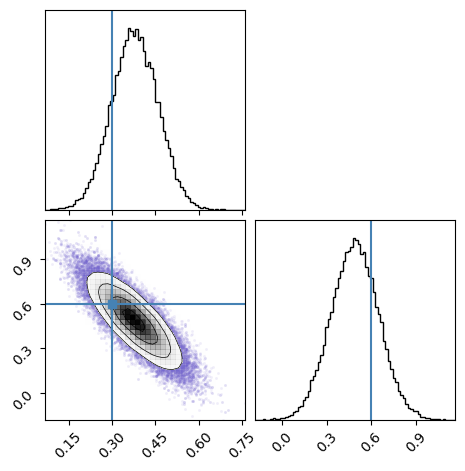

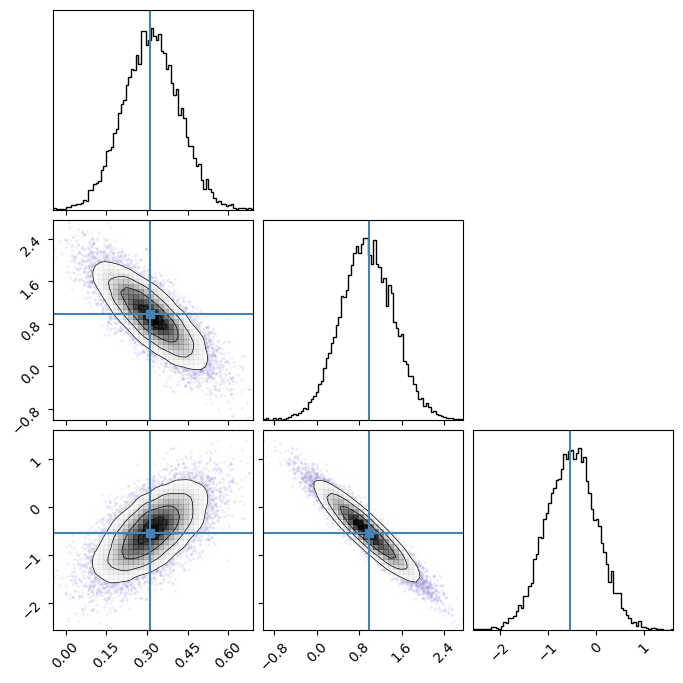

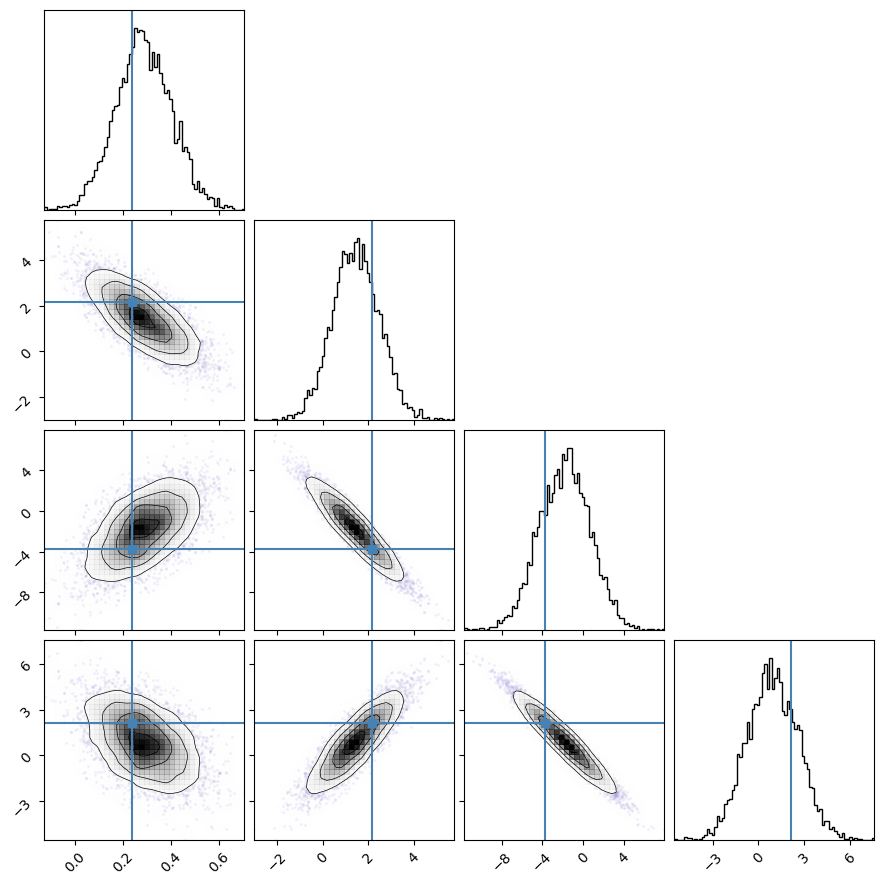

In [39]:
# corner plots to check sampling within each state
if(plotting):
    muplot = mls.copy()
    muplot[1] = mtrue
    # collect trans samples
    transc_ensemble,model_chain,states_chain = key.get_transc_samples(100000,discard=0,thin=thin,flat=True,returnchains=True)
    contour_kwargs = {"linewidths" : 0.5}
    data_kwargs = {"color" : "slateblue"}
    for i in range(1,nstates):
        string = 'Order '+str(i)
        print(' State; ',i,' in ',ndims[i],' dimensions')
        fig = corner.corner(
            flatten_extend(transc_ensemble[i]).reshape(-1,ndims[i]), 
            truths=muplot[i],
            title=string,
            bins=40,hist_bin_factor=2,smooth=True,contour_kwargs=contour_kwargs,data_kwargs=data_kwargs
            );

In [40]:
print(' Here is the Trans-C ensemble with\n {} samples in state 1\n {} samples in state 2\n {} samples in state 3\n'
      .format(len(transc_ensemble[0]),len(transc_ensemble[1]),len(transc_ensemble[2])),'\n',transc_ensemble)

 Here is the Trans-C ensemble with
 16980 samples in state 1
 65194 samples in state 2
 12490 samples in state 3
 
 [array([[0.56385601],
       [0.59505461],
       [0.52925882],
       ...,
       [0.58980625],
       [0.61109962],
       [0.55511016]], shape=(16980, 1)), array([[0.38049268, 0.54933289],
       [0.4118639 , 0.42231407],
       [0.31806249, 0.77605425],
       ...,
       [0.4595915 , 0.18218665],
       [0.40346216, 0.45767513],
       [0.31861505, 0.63384529]], shape=(65194, 2)), array([[ 0.33786367,  1.32561621, -0.93906949],
       [ 0.21902561,  0.91599259, -0.28858259],
       [ 0.24359385,  1.65605903, -1.45146174],
       ...,
       [ 0.4651894 ,  0.15596409,  0.33028613],
       [ 0.43082489,  0.36961033, -0.06732613],
       [ 0.2122283 ,  1.42847854, -0.75279213]], shape=(12490, 3)), array([[ 0.38472907,  0.92305452, -0.39541837, -0.04554457],
       [ 0.39623464, -0.72768629,  3.00353747, -1.72559368],
       [ 0.13222615,  2.50349648, -5.35374833,  4.018

---------